For me always was interesting, which effect different optimizers will have on the final results of the model, when it's structure and data are the same. Beight the way of realization of back propagation algorithm, optimizer is one the most influential elements of the training process and difference between them also could take place.

For the experement I will use a 'https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification' dataset. 

In [209]:
import torch
import os
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
from torch import nn
import torch.nn.functional as F


from torch.optim import Adam, SGD, RMSprop, Adagrad

import matplotlib.pyplot as plt
import numpy as np 
from tqdm import tqdm

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

In [261]:
# os.remove("")

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
device

'cuda'

In [4]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomRotation(degrees=45),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    
])

In [5]:
root_dir = "/kaggle/input/satellite-image-classification/data"

dataset = datasets.ImageFolder(root=root_dir, transform=transform)

In [7]:
classes = dataset.classes
classes

['cloudy', 'desert', 'green_area', 'water']

In [6]:
len(dataset)

5631

In [8]:
train_ratio = 0.8

generator = torch.Generator(device=device)
train_dataset, test_dataset, val_dataset = random_split(dataset, [train_ratio, 0.9 - train_ratio, 0.9 - train_ratio])

In [9]:
len(train_dataset), len(test_dataset), len(val_dataset)

(4505, 563, 563)

In [10]:
def output(limit, data):
    num = 0
    for img, cls in data:

        img = img.permute(1, 2, 0)
        plt.imshow(img)
        plt.title(classes[int(cls)])
        plt.axis("off")
        plt.show()

        num += 1

        if num >= limit:
            break

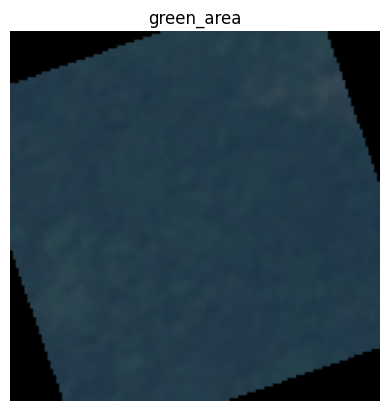

In [11]:
output(1, train_dataset)

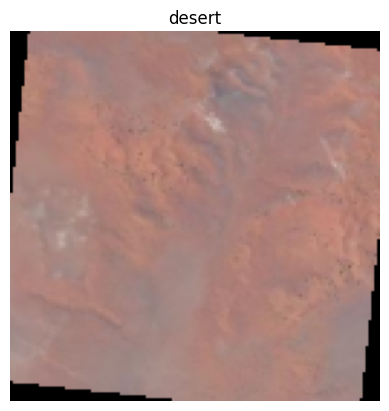

In [12]:
output(1, test_dataset)

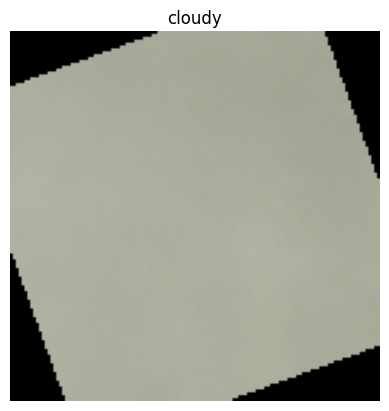

In [13]:
output(1, val_dataset)

In [124]:
batch_size = 16

train_dl = DataLoader(train_dataset, batch_size=batch_size, generator=torch.Generator(device='cpu'))
val_dl = DataLoader(val_dataset, batch_size=batch_size, generator=torch.Generator(device='cpu'))

In [15]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, additional_pooling=False):
        super().__init__()
        # 128, 128, 3
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 64, 64, 32
        if additional_pooling:
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        else: 
            self.pool2 = None

    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = self.pool1(out)   
        out = F.relu(out)
        if self.pool2 is not None:
            out = self.pool2(out)
            out = F.relu(out)

        return out
    

In [17]:
class LinearBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout = None, bnorm=False, output_layer=False):
        super().__init__()

        self.linear = nn.Linear(in_channels, out_channels)

        if dropout is not None:
            self.dropout = nn.Dropout(dropout)
        else:

            self.dropout = None

        if bnorm:
            self.bnorm = nn.BatchNorm1d(out_channels)
        else:
            self.bnorm = None

        
        self.output_layer = output_layer

    def forward(self, x):
        out = self.linear(x)
        if self.bnorm is not None:
            out = self.bnorm(out)

        if not self.output_layer:
            out = F.relu(out)
            
        if self.dropout is not None and not self.output_layer:
            out = self.dropout(out)

        return out 
        
            

In [196]:
class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()

        # 3, 128, 128
        self.conv1 = ConvBlock(in_channels=3, out_channels=32)
        # 32, 64, 64
        self.conv2 = ConvBlock(in_channels=32, out_channels=64)
        # 64, 32, 32
        self.conv3 = ConvBlock(in_channels=64, out_channels=128)
        # 128, 16, 16
        self.conv4 = ConvBlock(in_channels=128, out_channels=256)
        # 256, 8, 8
        self.conv5 = ConvBlock(in_channels=256, out_channels=512, additional_pooling=True)
        # 512, 4, 4

        self.flatten = nn.Flatten()
        # 2048

        self.linear1 = LinearBlock(2048, 512, 0.3, bnorm=True)
        self.linear2 = LinearBlock(512, 128, bnorm=True)
        self.linear3 = LinearBlock(128, 32, 0.3, bnorm=True)
        self.linear4 = LinearBlock(32, 8)
        self.linear5 = LinearBlock(8, 4, output_layer=True)

    def forward(self, x):

        # print(x.size())

        out = self.conv1(x)
        # print(out.size())
        
        out = self.conv2(out)
        # print(out.size())
        
        out = self.conv3(out)
        # print(out.size())
        
        out = self.conv4(out)
        # print(out.size())
        
        out = self.conv5(out)
        # print(out.size())
       

        out_ = self.flatten(out)
        # print(f"Flatten: {out_.size()}")

        out_ = self.linear1(out_)
        # print(out_.size())
        
        out_ = self.linear2(out_)
        # print(out_.size())
        
        out_ = self.linear3(out_)
        # print(out_.size())
        
        out_ = self.linear4(out_)
        # print(out_.size())
        
        res = self.linear5(out_)
        # print(res.size())

        return res


    def predict(self, x):
        self.eval()

        with torch.no_grad():
            res = self.forward(x)
            t_pred = F.softmax(res, dim=1)
            pred = torch.argmax(t_pred, dim=1)

            return pred



model_1 = CustomModel()
model_1 = model_1.to(device)

In [197]:
x = torch.randn(4, 3, 128, 128).to(device)  

output = model_1(x)
print("Output:", output.shape)

Output: torch.Size([4, 4])


In [20]:
!pip install -q torchsummary

In [198]:
from torchsummary import summary

summary(model_1, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
         ConvBlock-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
         ConvBlock-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
         ConvBlock-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 256, 16, 16]         295,168
        MaxPool2d-11            [-1, 256, 8, 8]               0
        ConvBlock-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 512, 8, 8]       1,180,160
        MaxPool2d-14            [-1, 51

In [200]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    
    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in tqdm(train_dl):
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    history_train[name] += func(y, y_pred) * x.size(0)
                except:
                    if task == 'binary': y_pred_ = y_pred.round()
                    elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                    history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in tqdm(val_dl):
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

**Adam**

![Adam](https://miro.medium.com/v2/resize:fit:1000/1*iRVS01R0ykMcStaY2rdSdw.png)

In [201]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model_1.parameters(), lr=1e-3)

In [26]:
device

'cuda'

In [202]:
from sklearn.metrics import accuracy_score

history = train(model_1, optimizer, loss_fn, train_dl, val_dl,
                epochs=10,
                metrics=[accuracy_score],
                device=device,
                task='multiclass')

train() called: model=CustomModel, opt=Adam(lr=0.001000), epochs=10, device=cuda



100%|██████████| 36/36 [00:01<00:00, 20.59it/s]


Epoch    1   19sec	loss:      0.734	val_loss:      0.761	accuracy_score:      0.722	val_accuracy_score:       0.68	


100%|██████████| 36/36 [00:01<00:00, 27.90it/s]


Epoch    2   14sec	loss:      0.489	val_loss:      0.795	accuracy_score:      0.805	val_accuracy_score:      0.639	


100%|██████████| 36/36 [00:01<00:00, 26.13it/s]


Epoch    3   14sec	loss:      0.449	val_loss:      0.326	accuracy_score:      0.824	val_accuracy_score:      0.863	


100%|██████████| 36/36 [00:01<00:00, 25.15it/s]


Epoch    4   14sec	loss:      0.421	val_loss:      0.353	accuracy_score:      0.837	val_accuracy_score:      0.865	


100%|██████████| 36/36 [00:01<00:00, 25.66it/s]


Epoch    5   15sec	loss:      0.403	val_loss:       1.92	accuracy_score:      0.845	val_accuracy_score:       0.49	


100%|██████████| 36/36 [00:01<00:00, 26.03it/s]


Epoch    6   15sec	loss:      0.397	val_loss:      0.924	accuracy_score:      0.846	val_accuracy_score:      0.622	


100%|██████████| 36/36 [00:01<00:00, 25.51it/s]


Epoch    7   16sec	loss:      0.384	val_loss:      0.276	accuracy_score:      0.849	val_accuracy_score:      0.888	


100%|██████████| 36/36 [00:01<00:00, 26.78it/s]


Epoch    8   16sec	loss:       0.37	val_loss:      0.248	accuracy_score:      0.859	val_accuracy_score:      0.925	


100%|██████████| 36/36 [00:01<00:00, 26.56it/s]


Epoch    9   15sec	loss:      0.367	val_loss:      0.333	accuracy_score:      0.862	val_accuracy_score:       0.86	


100%|██████████| 36/36 [00:01<00:00, 26.69it/s]

Epoch   10   14sec	loss:      0.358	val_loss:      0.239	accuracy_score:      0.858	val_accuracy_score:      0.915	

Time total:     152.55 sec


In [203]:
def metric_output(name, history):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label="train")
    plt.plot(history["val_" + name], label="validation")
    plt.xlabel("Epochs")
    plt.ylabel(name)
    plt.legend()

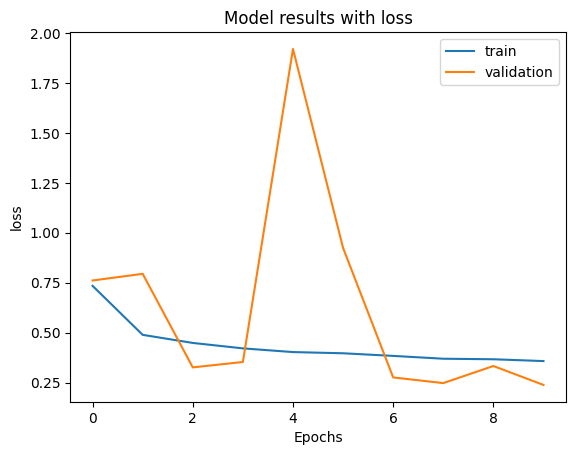

In [204]:
metric_output("loss", history)

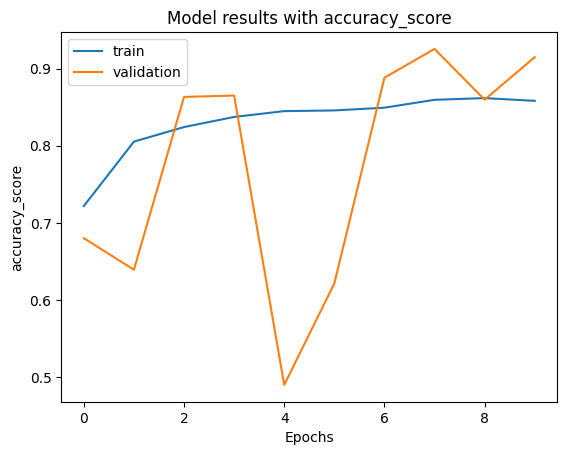

In [205]:
metric_output("accuracy_score", history)

In [206]:

def evaluate(test_data, model):

    t_model = model.to(device)
    
    total_loss = 0
    total_acc = 0
    
    with torch.no_grad():
        for x_test, y_test in tqdm(test_data):
            x_test = x_test.to(device)
            y_test = y_test.to(device)
    
            y_preds = t_model(x_test)
    
            cur_loss = loss_fn(y_preds, y_test)
            total_loss += cur_loss.item()
    
            y_preds = torch.argmax(y_preds, dim=1)
            cur_acc = accuracy_score(y_test.cpu().numpy(), y_preds.cpu().numpy())
            total_acc += cur_acc.item()
    
    
    loss = total_loss / len(test_dl)
    acc = total_acc / len(test_dl)

    return f"[Loss: {round(loss, 2)}, accuracy: {round(acc, 2)}]"



In [220]:
res = evaluate(test_dl, model_1)
res

100%|██████████| 5/5 [00:01<00:00,  3.66it/s]


'[Loss: 0.26, accuracy: 0.92]'

In [211]:
batch_size = 128
test_dl = DataLoader(test_dataset, batch_size=batch_size, generator=torch.Generator(device='cpu'))

In [212]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_metric(model, test_set, class_list=None):
    t_model = model.to('cpu')
    t_model.eval()
    x_test, y_test = next(iter(test_set))
    
    # USE PREDICT INSTEAD OF JUST 'MODEL'
    y_pred = t_model.predict(x_test)
    
    y_pred = y_pred.numpy()
    
    
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = class_list)
    plt.xticks(rotation=90)
    plt.plot()

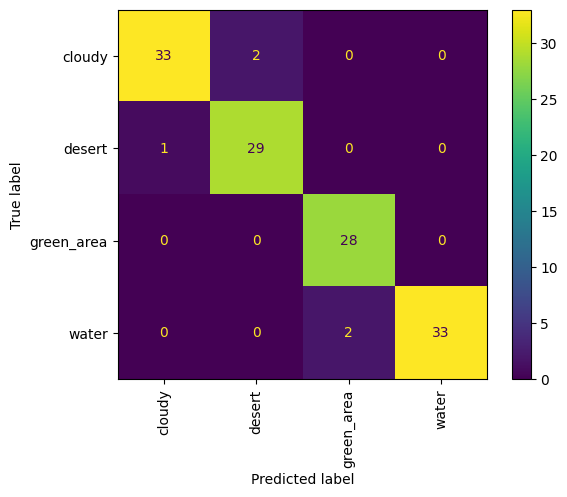

In [227]:
plot_metric(model_1, test_dl, class_list = classes)

In [214]:
torch.save(model.state_dict(), "adam_model.pt")

Non-stable learning process (with validation set), best results: [Loss: 0.25, accuracy: 0.92]
Data may be too simple, but model_1 still must work good. Use fewer epochs, few batch_size and learning rate near the 1e-3. 

Enough dropout value is near 0.3. It shouldn't be more then 2-3 dropout layer. Batch normalization also increases a results, but in general it't influence is low. 

**SGD**

![SGD](https://cdn-images-1.medium.com/max/800/1*kvwgxqwUskRcuXUCr_GFZA@2x.png)

In [216]:
model_2 = CustomModel()
model_2 = model_2.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = SGD(model_2.parameters(), lr=1e-4, momentum=0.99)

In [218]:
history_2 = train(model_2, optimizer, loss_fn, train_dl, val_dl,
                epochs=20,
                metrics=[accuracy_score],
                device=device,
                task='multiclass')

train() called: model=CustomModel, opt=SGD(lr=0.000100), epochs=20, device=cuda



100%|██████████| 36/36 [00:01<00:00, 28.72it/s]


Epoch    1   14sec	loss:       1.16	val_loss:      0.806	accuracy_score:      0.494	val_accuracy_score:      0.661	


100%|██████████| 36/36 [00:01<00:00, 27.94it/s]


Epoch    2   14sec	loss:      0.679	val_loss:      0.447	accuracy_score:      0.748	val_accuracy_score:      0.876	


100%|██████████| 36/36 [00:01<00:00, 28.46it/s]


Epoch    3   14sec	loss:      0.508	val_loss:      0.287	accuracy_score:      0.816	val_accuracy_score:      0.925	


100%|██████████| 36/36 [00:01<00:00, 28.06it/s]


Epoch    4   14sec	loss:      0.438	val_loss:      0.303	accuracy_score:      0.838	val_accuracy_score:      0.908	


100%|██████████| 36/36 [00:01<00:00, 27.34it/s]


Epoch    5   14sec	loss:      0.431	val_loss:      0.267	accuracy_score:       0.84	val_accuracy_score:      0.902	


100%|██████████| 36/36 [00:01<00:00, 28.80it/s]


Epoch    6   14sec	loss:      0.383	val_loss:      0.211	accuracy_score:      0.863	val_accuracy_score:      0.943	


100%|██████████| 36/36 [00:01<00:00, 29.51it/s]


Epoch    7   14sec	loss:      0.358	val_loss:      0.316	accuracy_score:       0.87	val_accuracy_score:      0.863	


100%|██████████| 36/36 [00:01<00:00, 25.47it/s]


Epoch    8   14sec	loss:       0.37	val_loss:      0.229	accuracy_score:       0.86	val_accuracy_score:       0.92	


100%|██████████| 36/36 [00:01<00:00, 25.96it/s]


Epoch    9   14sec	loss:      0.364	val_loss:      0.218	accuracy_score:       0.87	val_accuracy_score:      0.911	


100%|██████████| 36/36 [00:01<00:00, 28.20it/s]


Epoch   10   14sec	loss:      0.354	val_loss:      0.378	accuracy_score:      0.869	val_accuracy_score:      0.833	


100%|██████████| 36/36 [00:01<00:00, 28.99it/s]


Epoch   11   14sec	loss:      0.348	val_loss:      0.214	accuracy_score:      0.867	val_accuracy_score:      0.929	


100%|██████████| 36/36 [00:01<00:00, 26.59it/s]


Epoch   12   14sec	loss:      0.319	val_loss:      0.342	accuracy_score:      0.883	val_accuracy_score:      0.858	


100%|██████████| 36/36 [00:01<00:00, 28.67it/s]


Epoch   13   14sec	loss:      0.329	val_loss:      0.234	accuracy_score:       0.88	val_accuracy_score:      0.913	


100%|██████████| 36/36 [00:01<00:00, 29.47it/s]


Epoch   14   14sec	loss:      0.363	val_loss:      0.285	accuracy_score:       0.86	val_accuracy_score:      0.879	


100%|██████████| 36/36 [00:01<00:00, 24.87it/s]


Epoch   15   14sec	loss:      0.321	val_loss:      0.194	accuracy_score:      0.881	val_accuracy_score:      0.925	


100%|██████████| 36/36 [00:01<00:00, 23.83it/s]


Epoch   16   14sec	loss:      0.294	val_loss:      0.153	accuracy_score:      0.895	val_accuracy_score:      0.948	


100%|██████████| 36/36 [00:01<00:00, 26.37it/s]


Epoch   17   14sec	loss:      0.289	val_loss:        0.3	accuracy_score:      0.892	val_accuracy_score:      0.858	


100%|██████████| 36/36 [00:01<00:00, 27.87it/s]


Epoch   18   14sec	loss:      0.286	val_loss:      0.188	accuracy_score:      0.895	val_accuracy_score:      0.938	


100%|██████████| 36/36 [00:01<00:00, 27.26it/s]


Epoch   19   14sec	loss:      0.271	val_loss:      0.208	accuracy_score:      0.898	val_accuracy_score:      0.925	


100%|██████████| 36/36 [00:01<00:00, 26.70it/s]

Epoch   20   14sec	loss:      0.272	val_loss:      0.181	accuracy_score:      0.899	val_accuracy_score:      0.934	

Time total:     278.72 sec


In [236]:
evaluate(test_dl, model_2)

100%|██████████| 5/5 [00:01<00:00,  3.59it/s]


'[Loss: 0.21, accuracy: 0.92]'

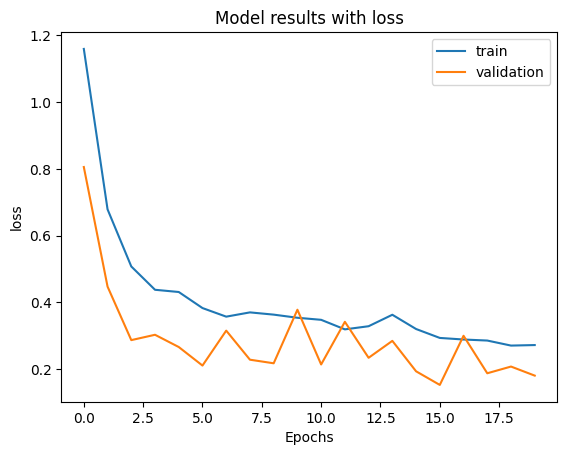

In [222]:
metric_output("loss", history_2)

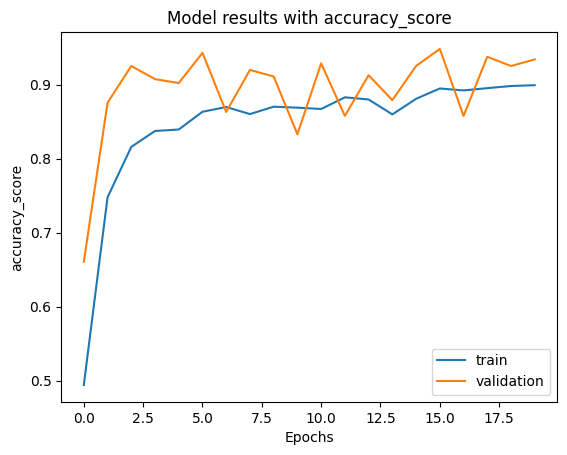

In [223]:
metric_output("accuracy_score", history_2)

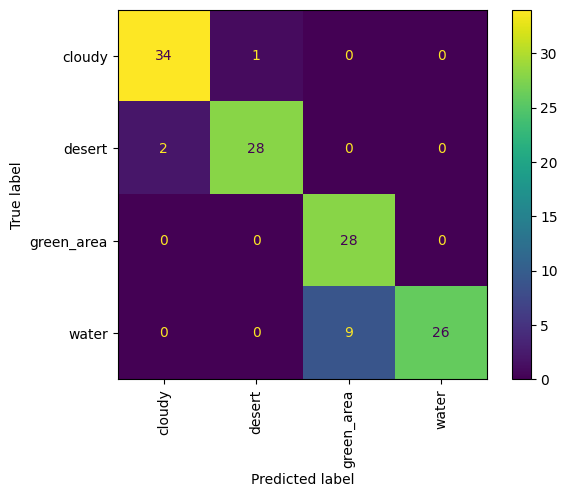

In [225]:
plot_metric(model_2, test_dl, class_list = classes)

In [226]:
torch.save(model_2.state_dict(), "sgd_model.pt")

SGD optimizer works quite better on this data with current model construction. It presents such results as [Loss: 0.21, accuracy: 0.92], which, actually, one od the best examples. It also shows the most stable learning process as with train as with validation sets. It needs near to 20 epochs or even more a little bit to perform better. 

It also need lower learning rate to handle gradients better - unlike Adam, RMSprop or Adagrad, SGD takes into account only currant gradients and calculates following, based on current one, so to have a stable gradients update, learning rate here sould be lower. 

This time SGD also use a momentum parameter, which shows hom much information from previouse gradient, it is going to take to calculate next one. It is also a reason to take lower learning rate. 

**RMSprop**

![](https://miro.medium.com/v2/resize:fit:1400/1*R5q73YgObhvSPws9RpNmPA.png)

In [258]:
model_3 = CustomModel()
model_3 = model_3.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = RMSprop(model_3.parameters(), lr=1e-4, momentum=0.9)

In [259]:
history_3 = train(model_3, optimizer, loss_fn, train_dl, val_dl,
                epochs=20,
                metrics=[accuracy_score],
                device=device,
                task='multiclass')

train() called: model=CustomModel, opt=RMSprop(lr=0.000100), epochs=20, device=cuda



100%|██████████| 36/36 [00:01<00:00, 24.43it/s]


Epoch    1   16sec	loss:      0.762	val_loss:      0.595	accuracy_score:       0.61	val_accuracy_score:      0.682	


100%|██████████| 36/36 [00:01<00:00, 23.93it/s]


Epoch    2   15sec	loss:      0.582	val_loss:      0.474	accuracy_score:      0.732	val_accuracy_score:       0.79	


100%|██████████| 36/36 [00:01<00:00, 26.59it/s]


Epoch    3   15sec	loss:      0.495	val_loss:      0.305	accuracy_score:      0.794	val_accuracy_score:      0.906	


100%|██████████| 36/36 [00:01<00:00, 25.01it/s]


Epoch    4   14sec	loss:      0.428	val_loss:       1.12	accuracy_score:      0.837	val_accuracy_score:      0.687	


100%|██████████| 36/36 [00:01<00:00, 24.97it/s]


Epoch    5   16sec	loss:      0.395	val_loss:      0.284	accuracy_score:      0.847	val_accuracy_score:      0.909	


100%|██████████| 36/36 [00:01<00:00, 23.69it/s]


Epoch    6   15sec	loss:       0.38	val_loss:      0.365	accuracy_score:       0.85	val_accuracy_score:      0.824	


100%|██████████| 36/36 [00:01<00:00, 23.82it/s]


Epoch    7   15sec	loss:      0.347	val_loss:      0.226	accuracy_score:      0.867	val_accuracy_score:      0.934	


100%|██████████| 36/36 [00:01<00:00, 24.65it/s]


Epoch    8   15sec	loss:      0.346	val_loss:      0.251	accuracy_score:      0.875	val_accuracy_score:      0.927	


100%|██████████| 36/36 [00:01<00:00, 26.75it/s]


Epoch    9   16sec	loss:      0.325	val_loss:      0.273	accuracy_score:       0.88	val_accuracy_score:       0.92	


100%|██████████| 36/36 [00:01<00:00, 24.60it/s]


Epoch   10   15sec	loss:      0.316	val_loss:      0.199	accuracy_score:      0.889	val_accuracy_score:      0.934	


100%|██████████| 36/36 [00:01<00:00, 25.11it/s]


Epoch   11   14sec	loss:      0.301	val_loss:      0.224	accuracy_score:      0.889	val_accuracy_score:      0.934	


100%|██████████| 36/36 [00:01<00:00, 25.95it/s]


Epoch   12   15sec	loss:      0.302	val_loss:      0.215	accuracy_score:      0.885	val_accuracy_score:      0.929	


100%|██████████| 36/36 [00:01<00:00, 24.78it/s]


Epoch   13   15sec	loss:      0.286	val_loss:      0.199	accuracy_score:      0.898	val_accuracy_score:      0.933	


100%|██████████| 36/36 [00:01<00:00, 25.89it/s]


Epoch   14   15sec	loss:      0.285	val_loss:      0.233	accuracy_score:      0.897	val_accuracy_score:      0.922	


100%|██████████| 36/36 [00:01<00:00, 25.20it/s]


Epoch   15   15sec	loss:      0.284	val_loss:      0.206	accuracy_score:      0.897	val_accuracy_score:      0.943	


100%|██████████| 36/36 [00:01<00:00, 25.37it/s]


Epoch   16   15sec	loss:      0.269	val_loss:      0.185	accuracy_score:        0.9	val_accuracy_score:       0.94	


100%|██████████| 36/36 [00:01<00:00, 26.89it/s]


Epoch   17   15sec	loss:      0.265	val_loss:      0.182	accuracy_score:      0.898	val_accuracy_score:      0.929	


100%|██████████| 36/36 [00:01<00:00, 29.85it/s]


Epoch   18   14sec	loss:      0.248	val_loss:      0.139	accuracy_score:      0.903	val_accuracy_score:       0.95	


100%|██████████| 36/36 [00:01<00:00, 28.29it/s]


Epoch   19   14sec	loss:      0.245	val_loss:      0.128	accuracy_score:      0.907	val_accuracy_score:      0.964	


100%|██████████| 36/36 [00:01<00:00, 28.44it/s]

Epoch   20   14sec	loss:      0.233	val_loss:      0.154	accuracy_score:      0.912	val_accuracy_score:      0.945	

Time total:     297.10 sec


In [260]:
evaluate(test_dl, model_3)

100%|██████████| 5/5 [00:01<00:00,  3.93it/s]


'[Loss: 0.17, accuracy: 0.92]'

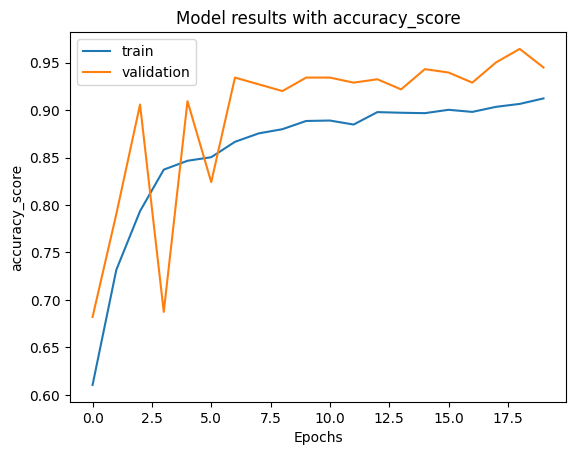

In [262]:
metric_output("accuracy_score", history_3)

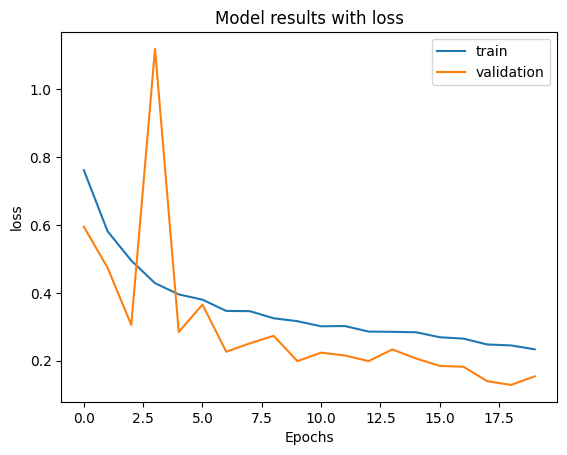

In [263]:
metric_output("loss", history_3)

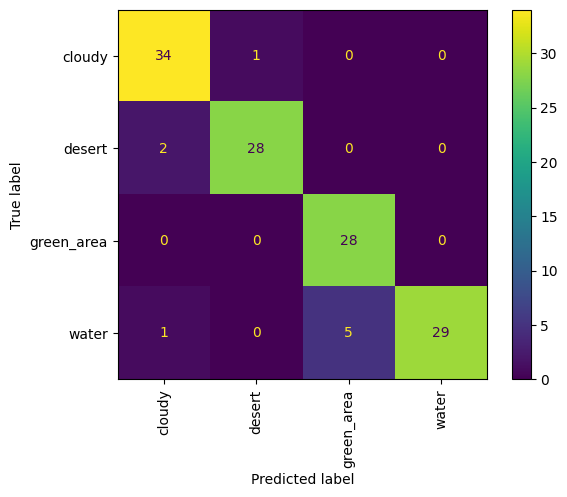

In [235]:
plot_metric(model_3, test_dl, class_list = classes)

In [266]:
torch.save(model_3.state_dict(), "rms_prop_model.pt")

At the begining, RMSprops provides unstable learning, but later, learning process stabilizes. It performes with '[Loss: 0.17, accuracy: 0.92]' results, which is the best result from all tested ones. 

To achieve that, especially learning stabilization, it needs a low learning rate, (unlike Adam which will just learn worse) and also a momentum parameter. So looks like usage of exponentally weighted average value of gradients helps to set the most correct learning speed, according, to RMSprop functionality. 

**Adagrad**

![](https://artemoppermann.com/wp-content/uploads/2021/08/image-54.png)

*impuls = momentum (how many information will be talen from previouse gradients, for SGD and RMSprop).

In [252]:
model_4 = CustomModel()
model_4 = model_4.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = Adagrad(model_4.parameters(), lr=1e-3)

In [253]:
history_4 = train(model_4, optimizer, loss_fn, train_dl, val_dl,
                epochs=30,
                metrics=[accuracy_score],
                device=device,
                task='multiclass')

train() called: model=CustomModel, opt=Adagrad(lr=0.001000), epochs=30, device=cuda



100%|██████████| 36/36 [00:01<00:00, 28.05it/s]


Epoch    1   14sec	loss:       1.13	val_loss:       1.08	accuracy_score:      0.667	val_accuracy_score:      0.625	


100%|██████████| 36/36 [00:01<00:00, 26.49it/s]


Epoch    2   15sec	loss:      0.923	val_loss:      0.802	accuracy_score:      0.853	val_accuracy_score:      0.933	


100%|██████████| 36/36 [00:01<00:00, 28.65it/s]


Epoch    3   15sec	loss:       0.82	val_loss:      0.701	accuracy_score:      0.887	val_accuracy_score:       0.94	


100%|██████████| 36/36 [00:01<00:00, 23.39it/s]


Epoch    4   15sec	loss:      0.741	val_loss:      0.741	accuracy_score:      0.904	val_accuracy_score:      0.803	


100%|██████████| 36/36 [00:01<00:00, 25.14it/s]


Epoch    5   14sec	loss:      0.679	val_loss:      0.616	accuracy_score:      0.911	val_accuracy_score:      0.865	


100%|██████████| 36/36 [00:01<00:00, 27.61it/s]


Epoch    6   15sec	loss:      0.628	val_loss:      0.636	accuracy_score:       0.92	val_accuracy_score:      0.835	


100%|██████████| 36/36 [00:01<00:00, 26.75it/s]


Epoch    7   15sec	loss:      0.582	val_loss:      0.585	accuracy_score:      0.924	val_accuracy_score:      0.853	


100%|██████████| 36/36 [00:01<00:00, 27.15it/s]


Epoch    8   14sec	loss:      0.547	val_loss:      0.573	accuracy_score:      0.932	val_accuracy_score:      0.856	


100%|██████████| 36/36 [00:01<00:00, 24.47it/s]


Epoch    9   15sec	loss:      0.522	val_loss:       0.48	accuracy_score:      0.931	val_accuracy_score:      0.911	


100%|██████████| 36/36 [00:01<00:00, 24.43it/s]


Epoch   10   15sec	loss:      0.487	val_loss:      0.413	accuracy_score:      0.934	val_accuracy_score:      0.968	


100%|██████████| 36/36 [00:01<00:00, 23.34it/s]


Epoch   11   15sec	loss:      0.464	val_loss:      0.591	accuracy_score:      0.939	val_accuracy_score:      0.826	


100%|██████████| 36/36 [00:01<00:00, 25.73it/s]


Epoch   12   15sec	loss:      0.441	val_loss:      0.502	accuracy_score:      0.939	val_accuracy_score:      0.867	


100%|██████████| 36/36 [00:01<00:00, 27.80it/s]


Epoch   13   14sec	loss:      0.421	val_loss:      0.396	accuracy_score:      0.941	val_accuracy_score:      0.922	


100%|██████████| 36/36 [00:01<00:00, 25.06it/s]


Epoch   14   15sec	loss:      0.399	val_loss:      0.407	accuracy_score:      0.942	val_accuracy_score:      0.877	


100%|██████████| 36/36 [00:01<00:00, 25.27it/s]


Epoch   15   15sec	loss:      0.385	val_loss:      0.482	accuracy_score:      0.945	val_accuracy_score:      0.863	


100%|██████████| 36/36 [00:01<00:00, 25.85it/s]


Epoch   16   14sec	loss:       0.37	val_loss:      0.376	accuracy_score:      0.944	val_accuracy_score:      0.913	


100%|██████████| 36/36 [00:01<00:00, 27.49it/s]


Epoch   17   15sec	loss:      0.352	val_loss:       0.36	accuracy_score:      0.948	val_accuracy_score:      0.915	


100%|██████████| 36/36 [00:01<00:00, 23.89it/s]


Epoch   18   15sec	loss:      0.343	val_loss:       0.32	accuracy_score:      0.948	val_accuracy_score:      0.925	


100%|██████████| 36/36 [00:01<00:00, 27.45it/s]


Epoch   19   15sec	loss:      0.333	val_loss:      0.427	accuracy_score:      0.949	val_accuracy_score:      0.863	


100%|██████████| 36/36 [00:01<00:00, 24.98it/s]


Epoch   20   15sec	loss:       0.32	val_loss:        0.5	accuracy_score:      0.952	val_accuracy_score:      0.853	


100%|██████████| 36/36 [00:01<00:00, 24.55it/s]


Epoch   21   14sec	loss:      0.314	val_loss:      0.361	accuracy_score:      0.953	val_accuracy_score:      0.906	


100%|██████████| 36/36 [00:01<00:00, 23.64it/s]


Epoch   22   15sec	loss:        0.3	val_loss:      0.532	accuracy_score:      0.953	val_accuracy_score:       0.81	


100%|██████████| 36/36 [00:01<00:00, 25.03it/s]


Epoch   23   15sec	loss:      0.294	val_loss:      0.555	accuracy_score:      0.956	val_accuracy_score:      0.815	


100%|██████████| 36/36 [00:01<00:00, 25.41it/s]


Epoch   24   15sec	loss:      0.279	val_loss:      0.516	accuracy_score:      0.957	val_accuracy_score:      0.819	


100%|██████████| 36/36 [00:01<00:00, 26.46it/s]


Epoch   25   14sec	loss:      0.269	val_loss:      0.387	accuracy_score:      0.962	val_accuracy_score:       0.89	


100%|██████████| 36/36 [00:01<00:00, 25.67it/s]


Epoch   26   15sec	loss:      0.262	val_loss:       1.05	accuracy_score:      0.962	val_accuracy_score:      0.673	


100%|██████████| 36/36 [00:01<00:00, 27.26it/s]


Epoch   27   14sec	loss:      0.255	val_loss:      0.418	accuracy_score:      0.959	val_accuracy_score:      0.872	


100%|██████████| 36/36 [00:01<00:00, 24.13it/s]


Epoch   28   14sec	loss:      0.251	val_loss:       0.19	accuracy_score:      0.962	val_accuracy_score:      0.972	


100%|██████████| 36/36 [00:01<00:00, 27.41it/s]


Epoch   29   14sec	loss:      0.239	val_loss:      0.158	accuracy_score:      0.965	val_accuracy_score:      0.982	


100%|██████████| 36/36 [00:01<00:00, 26.27it/s]

Epoch   30   15sec	loss:      0.233	val_loss:      0.394	accuracy_score:      0.966	val_accuracy_score:      0.861	

Time total:     439.61 sec


In [264]:
evaluate(test_dl, model_4)

100%|██████████| 5/5 [00:01<00:00,  3.94it/s]


'[Loss: 0.39, accuracy: 0.86]'

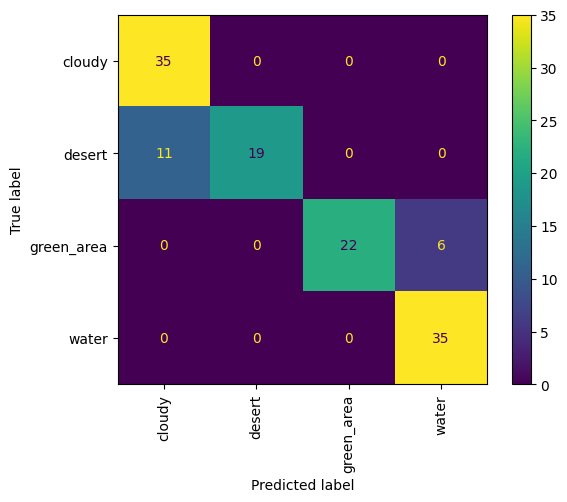

In [255]:
plot_metric(model_4, test_dl, class_list = classes)

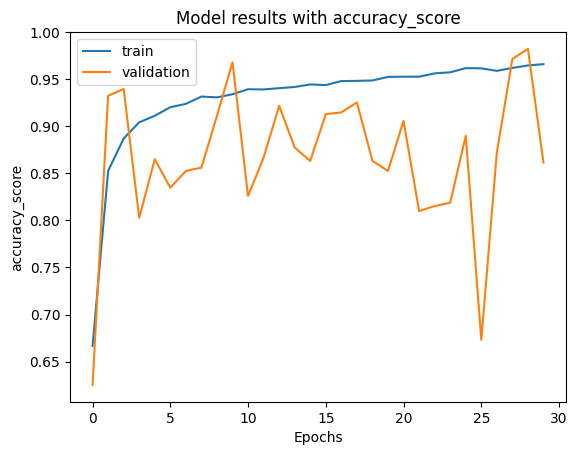

In [256]:
metric_output("accuracy_score", history_4)

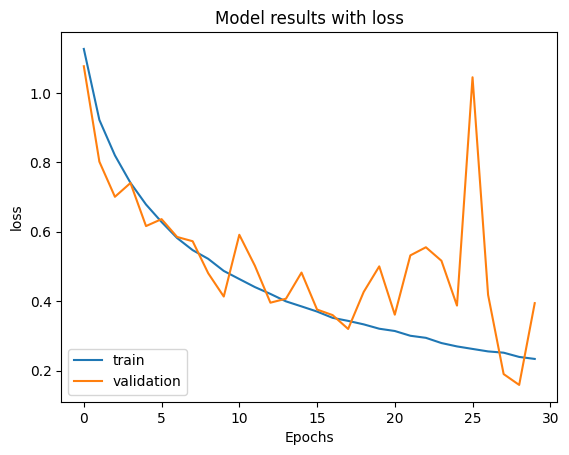

In [265]:
metric_output("loss", history_4)

In [267]:
torch.save(model_4.state_dict(), "adagrad_model.pt")

Adagrad performs itself in the worst way among other models. '[Loss: 0.39, accuracy: 0.86]' results aren't bad, but other ones just better. Learning rate has no effect on Adagrad performance here - it always firstly returns better results, but closer to the end, model in fact slows down it's learning, what could led to losses increasing, especially on validation set. So learning speed calculation, based on squared summa of gradients according to Adagrad formula doesn't work really good in this case. 

**Conclusion**

10.10.2024:
As was expected, different optimizers really make quite different effect on the final results. The best perfomance had RMSprop, which sets learing speed based on exponentially weighted value of gradients. In combination with right learning rate it led to pretty good results. Other two - Adam and SGD returned almost same results, but Adagrad performed itself in the worse way. 

But beight the best option for this specific case, RMSprop is not universal. This time the data - images of the landscape from the satellite was quite easy to classify into 4 classes. In more difficult cases, where model needs to extract more features and make the more detailed, which needs more learning epochs to learn patterns correctly or where model, for example, has more than one output, such optimizers as Adagrad or Adam could perform themself better. 

*To be continued...*
